In [1]:
# Import core libraries for data handling
import pandas as pd
import numpy as np


In [2]:
!pip install radon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.2 MB/s eta 0:00:00


In [3]:
# Import radon for code metrics (maintainability, complexity, lines of code)
from radon.raw import analyze as raw_metrics
from radon.complexity import cc_visit
from radon.metrics import mi_visit

In [4]:
# Import HuggingFace tools for semantic similarity (CodeBERT model)
from transformers import AutoTokenizer, AutoModel
import torch

In [5]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.8 MB/s eta 0:00:00


In [6]:
# Import sacrebleu for token based similarity
from sacrebleu.metrics import BLEU

In [7]:
# Load dataset from Kaggle input path
df = pd.read_csv("/kaggle/input/laboratory3/diff_analysis.csv")
print("Data loaded with shape:", df.shape)
print("Columns:", df.columns.tolist())

Data loaded with shape: (454, 8)
Columns: ['#', 'Message', 'Filename', 'Source Code (before)', 'Source Code (current)', 'Diff', 'Fix Type (LLM)', 'Rectified Message']


In [8]:
print(df.head())

                                          #  \
0  c02a213f8ea8d8873e8045a089fae4ac2637b8b4   
1  1c816c9fe4c6cf3986890f0a19142bb3c3b08a8f   
2  2c0b6cfbad8cd8a8067a50c3e15279e4d699d0bd   
3  fa61141a57676b11cab3b0df135fa6898b97abac   
4  ed2c3a1fdc36bc60cbe34f94efbb213e942755bb   

                                             Message      Filename  \
0  scoring.py: Handle entries without initial_res...    scoring.py   
1  scoring.py: Handle entries without initial_res...    scoring.py   
2                   fix typo in cloning installation    README.rst   
3          Raise a better error for a missing pyglet  rendering.py   
4                           README: Fix package name    README.rst   

                                Source Code (before)  \
0  """This is the actual code we use to score peo...   
1  """This is the actual code we use to score peo...   
2  gym\n******\n\n**OpenAI Gym is a toolkit for d...   
3  """\n2D rendering framework\n"""\nfrom __futur...   
4  gym\n******\n

In [9]:
print(df.tail())

                                            #  \
449  d337f4e5719bb8b49f2f9fba1501fe7749fa4d5c   
450  d337f4e5719bb8b49f2f9fba1501fe7749fa4d5c   
451  d337f4e5719bb8b49f2f9fba1501fe7749fa4d5c   
452  d337f4e5719bb8b49f2f9fba1501fe7749fa4d5c   
453  d337f4e5719bb8b49f2f9fba1501fe7749fa4d5c   

                                               Message               Filename  \
449  TimeLimit refactor with Monitor Simplification...                play.py   
450  TimeLimit refactor with Monitor Simplification...          monitoring.py   
451  TimeLimit refactor with Monitor Simplification...       test_wrappers.py   
452  TimeLimit refactor with Monitor Simplification...          time_limit.py   
453  TimeLimit refactor with Monitor Simplification...  write_rollout_data.py   

                                  Source Code (before)  \
449                                                NaN   
450  import gym\nfrom gym import monitoring\nfrom g...   
451  import gym\nfrom gym import error\nfrom

In [10]:
# Prepare column references
col_commit = "#"                           # commit identifier column
col_file = "Filename"                      # file name column
col_before = "Source Code (before)"        # code before fix
col_after = "Source Code (current)"        # code after fix
col_fix = "Fix Type (LLM)"                 # fix type column

In [11]:
# Basic descriptive stats
num_commits = df[col_commit].nunique()
num_files = df[col_file].nunique()
files_per_commit = df.groupby(col_commit)[col_file].nunique().mean()
fix_distribution = df[col_fix].value_counts()
ext_counts = df[col_file].apply(lambda x: str(x).split(".")[-1]).value_counts()

print("Commits:", num_commits)
print("Unique files:", num_files)
print("Avg files per commit:", round(files_per_commit, 2))
print("Fix type distribution:\n", fix_distribution)
print("Most common extensions:\n", ext_counts.head(5))


Commits: 187
Unique files: 132
Avg files per commit: 2.33
Fix type distribution:
 Fix Type (LLM)
add missing import                            20
add missing docstring                         10
add missing comment                            7
add missing game variables                     6
update env.py                                  6
                                              ..
update manifest.py                             1
add test for atexit_register                   1
add documentation for object.close()           1
add a new close registry class                 1
add more info about memory usage in travis     1
Name: count, Length: 359, dtype: int64
Most common extensions:
 Filename
py      403
cfg      13
rst      11
yml       8
json      6
Name: count, dtype: int64


In [ ]:
# Function to compute radon metrics for one source string
def radon_stats(src: str):
    # normalize input
    if src is None:
        src = ""
    src = str(src)

    try:
        # raw metrics -> use sloc (source lines) if available, else loc
        raw = raw_metrics(src)
        loc = getattr(raw, "sloc", getattr(raw, "loc", 0))

        # cc_visit -> returns block objects (Function / Class) with .complexity
        cc_blocks = cc_visit(src)
        cc_vals = []
        for b in cc_blocks:
            # b usually has .complexity; if not, try numeric fallback
            cc_vals.append(getattr(b, "complexity", float(b) if isinstance(b, (int, float)) else 0))
        cc = float(np.mean(cc_vals)) if cc_vals else 0.0

        # mi_visit -> return type can vary by mode/version; handle both scalar and iterable
        mi_res = mi_visit(src, multi=True)
        if isinstance(mi_res, (list, tuple)):
            mi_vals = [getattr(m, "mi", m) for m in mi_res]
            mi = float(np.mean(mi_vals)) if mi_vals else np.nan
        else:
            # mi_res might be a namedtuple with .mi or a scalar float
            mi = float(getattr(mi_res, "mi", mi_res))

        return mi, cc, loc

    except Exception as e:
        print("radon_stats error:", e, " (snippet start: )", repr(src)[:200])
        return np.nan, np.nan, np.nan

In [15]:
# compute BEFORE metrics
results_before = df[col_before].fillna("").astype(str).apply(radon_stats)
df[["MI_Before","CC_Before","LOC_Before"]] = pd.DataFrame(results_before.tolist(), index=df.index)

# compute AFTER metrics
results_after = df[col_after].fillna("").astype(str).apply(radon_stats)
df[["MI_After","CC_After","LOC_After"]] = pd.DataFrame(results_after.tolist(), index=df.index)

df["MI_Change"]  = df["MI_After"] - df["MI_Before"]
df["CC_Change"]  = df["CC_After"] - df["CC_Before"]
df["LOC_Change"] = df["LOC_After"] - df["LOC_Before"]


radon_stats error: SyntaxError at line: 4  (snippet start: ) "gym\n******\n\n**OpenAI Gym is a toolkit for developing and comparing reinforcement learning algorithms.** This is the ``gym`` open-source library, which gives you access to an ever-growing variety o
radon_stats error: SyntaxError at line: 4  (snippet start: ) "gym\n******\n\n**OpenAI Gym is a toolkit for developing and comparing reinforcement learning algorithms.** This is the ``gym`` open-source library, which gives you access to an ever-growing variety o
radon_stats error: SyntaxError at line: 4  (snippet start: ) "gym\n******\n\n**OpenAI Gym is a toolkit for developing and comparing reinforcement learning algorithms.** This is the ``gym`` open-source library, which gives you access to an ever-growing variety o
radon_stats error: SyntaxError at line: 4  (snippet start: ) "gym\n******\n\n**OpenAI Gym is a toolkit for developing and comparing reinforcement learning algorithms.** This is the ``gym`` open-source library, whic

In [16]:
# Setup CodeBERT model and tokenizer for semantic similarity
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

2025-09-04 16:20:28.472208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757002828.660888      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757002828.711599      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [17]:
# Helper to get mean pooled embeddings
def get_embedding(texts):
    enc = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1).expand(out.size()).float()
        pooled = (out * mask).sum(1) / mask.sum(1)
    return pooled.cpu().numpy()


In [ ]:
# compute CodeBERT semantic similarities in batches and handle empty code safely
import math

def embed_texts_batched(texts, batch_size=16):
    """Return numpy array (n_rows, hidden_size) of embeddings; empty strings -> zero vector."""
    all_embs = []
    hidden_size = model.config.hidden_size if hasattr(model.config, "hidden_size") else 768
    n = len(texts)
    for i in range(0, n, batch_size):
        batch = texts[i:i+batch_size]
        # mark which are empty
        empty_mask = [not bool(str(x).strip()) for x in batch]
        # replace empties with a single space so tokenizer works, but we'll zero them out post-embedding
        processed = [str(x) if str(x).strip() else " " for x in batch]
        enc = tokenizer(processed, padding=True, truncation=True, max_length=512, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc).last_hidden_state
            mask = enc["attention_mask"].unsqueeze(-1).expand(out.size()).float()
            pooled = (out * mask).sum(1) / mask.sum(1)
            pooled = pooled.cpu().numpy()
        # zero-out embeddings corresponding to original empty strings
        for j, is_empty in enumerate(empty_mask):
            if is_empty:
                pooled[j] = np.zeros(pooled.shape[1], dtype=float)
        all_embs.append(pooled)
    return np.vstack(all_embs)

before_list = df[col_before].astype(str).tolist()
after_list  = df[col_after].astype(str).tolist()

batch_size = 16
emb_before = embed_texts_batched(before_list, batch_size=batch_size)
emb_after  = embed_texts_batched(after_list, batch_size=batch_size)

# compute cosine similarities row-wise 
semantic_sims = []
for a, b in zip(emb_before, emb_after):
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    sim = float(np.dot(a, b) / denom) if denom != 0 else 0.0
    semantic_sims.append(sim)

df["Semantic_Similarity"] = semantic_sims
print("Computed Semantic_Similarity (batched). Example:")
df[["Semantic_Similarity"]].head()


Computed Semantic_Similarity (batched). Example:


,Semantic_Similarity
0,0.999688
1,0.999688
2,0.999963
3,0.998060
4,1.000000


In [19]:
# Compute semantic similarity for each row
sims = []
for before, after in zip(df[col_before].astype(str), df[col_after].astype(str)):
    emb1 = get_embedding([before])[0]
    emb2 = get_embedding([after])[0]
    sim = float(np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2)))
    sims.append(sim)
df["Semantic_Similarity"] = sims


In [20]:
# Compute BLEU token similarity for each row
bleu = BLEU(effective_order=True)
token_sims = []
for before, after in zip(df[col_before].astype(str), df[col_after].astype(str)):
    score = bleu.sentence_score(after, [before]).score / 100
    token_sims.append(score)
df["Token_Similarity"] = token_sims


In [ ]:
# Classification into major/minor and agreement check
df["Semantic_Class"] = df["Semantic_Similarity"].apply(lambda x: "Minor" if x >= 0.80 else "Major")
df["Token_Class"] = df["Token_Similarity"].apply(lambda x: "Minor" if x >= 0.75 else "Major")
df["Classes_Agree"] = np.where(df["Semantic_Class"] == df["Token_Class"], "YES", "NO")

In [ ]:
# Save the enriched dataset
df.to_csv("lab3_output.csv", index=False)
print("Saved lab3_output.csv with new metrics and classifications")

Saved lab3_output.csv with new metrics and classifications


In [ ]:
# Simple report of conflicting cases
conflicts = df[df["Classes_Agree"] == "NO"]
print("Number of conflicts:", len(conflicts))
print(conflicts[[col_commit, col_file, "Semantic_Similarity", "Token_Similarity", "Semantic_Class", "Token_Class"]].head(10))

Number of conflicts: 31
                                            #               Filename  \
47   8c864953a4620b89a285bac043669b23c36b2c5e    reraise_impl_py3.py   
121  c2587d2bb76c3ab1b882872328caf89a76fd0b36      bipedal_walker.py   
122  c2587d2bb76c3ab1b882872328caf89a76fd0b36        lunar_lander.py   
133  7371debe38da7f6dc2c1403528db6e42e7238706            __init__.py   
172  58e6aa95e5af2c738557431f812abb81c505a7cf       configuration.py   
266  aff7a643cc67c7c7a3a9d9a705dda803072807d7            controls.md   
267  aff7a643cc67c7c7a3a9d9a705dda803072807d7          doom_basic.py   
268  aff7a643cc67c7c7a3a9d9a705dda803072807d7       doom_corridor.py   
269  aff7a643cc67c7c7a3a9d9a705dda803072807d7     doom_deathmatch.py   
270  aff7a643cc67c7c7a3a9d9a705dda803072807d7  doom_defend_center.py   

     Semantic_Similarity  Token_Similarity Semantic_Class Token_Class  
47              0.962625          0.332727          Minor       Major  
121             0.989622          0.722

In [24]:
# quick check to ensure similarity columns were added correctly
print("Sample rows with key columns:")
df[[col_commit, col_file, "MI_Change", "CC_Change", "LOC_Change", "Semantic_Similarity"]].head()

Sample rows with key columns:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,#,Filename,MI_Change,CC_Change,LOC_Change,Semantic_Similarity
0,c02a213f8ea8d8873e8045a089fae4ac2637b8b4,scoring.py,0.302534,0.0,0.0,0.999688
1,1c816c9fe4c6cf3986890f0a19142bb3c3b08a8f,scoring.py,0.302534,0.0,0.0,0.999688
2,2c0b6cfbad8cd8a8067a50c3e15279e4d699d0bd,README.rst,NaN,NaN,NaN,0.999963
3,fa61141a57676b11cab3b0df135fa6898b97abac,rendering.py,-0.334417,0.0,4.0,0.998060
4,ed2c3a1fdc36bc60cbe34f94efbb213e942755bb,README.rst,NaN,NaN,NaN,1.000000


In [25]:
df["Extension"] = df["Filename"].apply(lambda x: str(x).split(".")[-1])
print(df["Extension"].value_counts())

Extension
py                   403
cfg                   13
rst                   11
yml                    8
json                   6
gitignore              2
benchmark_runner       2
dockerfile             2
md                     2
play_go                1
project                1
pydevproject           1
docker_entrypoint      1
upload                 1
Name: count, dtype: int64


In [26]:
print("Sample BEFORE code:\n", df[col_before].dropna().iloc[0][:500])
print("\nSample AFTER code:\n", df[col_after].dropna().iloc[0][:500])

Sample BEFORE code:
 """This is the actual code we use to score people's solutions
server-side. The interfaces here are not yet stable, but we include
them so that people can reproduce our scoring calculations
independently.

We correspondly do not currently import this module.
"""

import numpy as np
import requests

import gym

def score_from_remote(url):
    result = requests.get(url)
    parsed = result.json()
    episode_lengths = parsed['episode_lengths']
    episode_rewards = parsed['episode_rewards']
    tim

Sample AFTER code:
 """This is the actual code we use to score people's solutions
server-side. The interfaces here are not yet stable, but we include
them so that people can reproduce our scoring calculations
independently.

We correspondly do not currently import this module.
"""

import numpy as np
import requests

import gym

def score_from_remote(url):
    result = requests.get(url)
    parsed = result.json()
    episode_lengths = parsed['episode_lengths']
    episode_

In [27]:
nan_report = df[["MI_Before", "CC_Before", "LOC_Before",
                 "MI_After", "CC_After", "LOC_After"]].isna().mean() * 100

print("Percentage of NaN values in radon metrics (before/after):")
print(nan_report.round(2))

Percentage of NaN values in radon metrics (before/after):
MI_Before     10.13
CC_Before     10.13
LOC_Before    10.13
MI_After       8.81
CC_After       8.81
LOC_After      8.81
dtype: float64


In [ ]:
# summary stats
print("Semantic_Similarity — mean / median / std:")
print(df["Semantic_Similarity"].describe().loc[["mean", "50%", "std"]])
print("\nToken_Similarity — mean / median / std:")
print(df["Token_Similarity"].describe().loc[["mean", "50%", "std"]])
print("\nMI_Change mean:", df["MI_Change"].mean(), "CC_Change mean:", df["CC_Change"].mean(), "LOC_Change mean:", df["LOC_Change"].mean())

Semantic_Similarity — mean / median / std:
mean    0.977567
50%     0.999929
std     0.077067
Name: Semantic_Similarity, dtype: float64

Token_Similarity — mean / median / std:
mean    0.854443
50%     0.975680
std     0.279867
Name: Token_Similarity, dtype: float64

MI_Change mean: -1.014899453942111 CC_Change mean: 0.10266621223867424 LOC_Change mean: 13.125


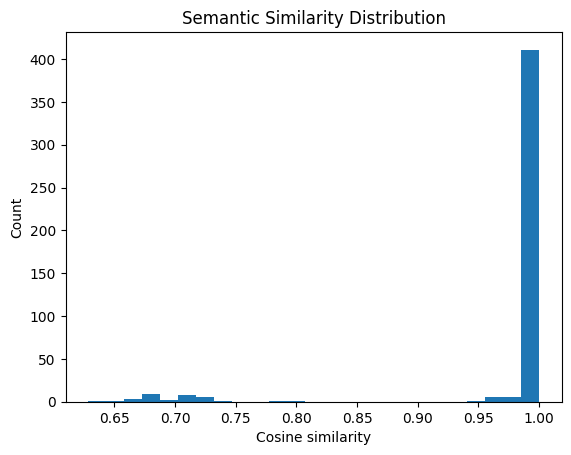

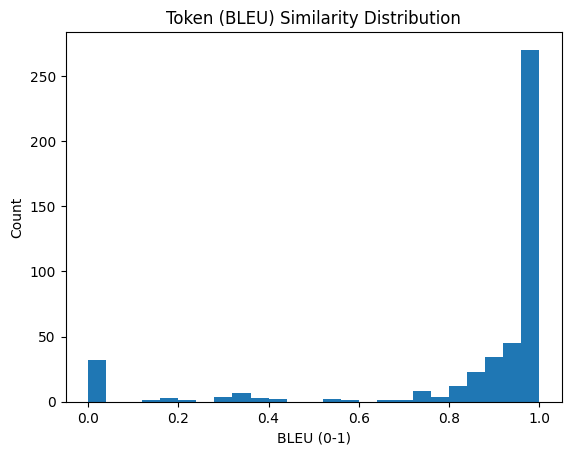

In [29]:
# plot histograms for semantic and token similarity distributions
import matplotlib.pyplot as plt

# Semantic similarity histogram
plt.figure()
plt.hist(df["Semantic_Similarity"].dropna(), bins=25)
plt.title("Semantic Similarity Distribution")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.show()

# Token similarity histogram
plt.figure()
plt.hist(df["Token_Similarity"].dropna(), bins=25)
plt.title("Token (BLEU) Similarity Distribution")
plt.xlabel("BLEU (0-1)")
plt.ylabel("Count")
plt.show()


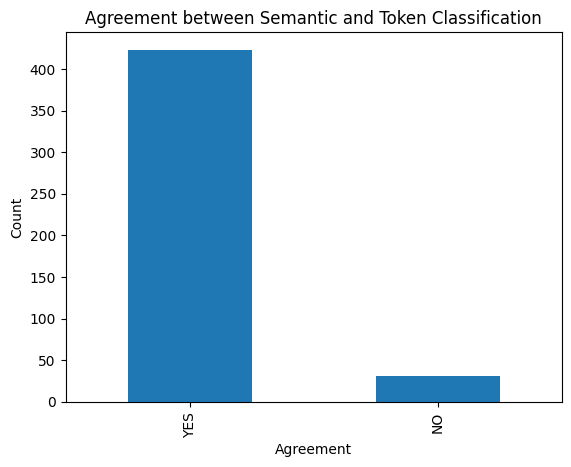

Agreement rate: 93.17%


In [30]:
# simple bar chart: agreement counts (YES / NO) and percent
import matplotlib.pyplot as plt

counts = df["Classes_Agree"].value_counts()
counts.plot(kind="bar")
plt.title("Agreement between Semantic and Token Classification")
plt.xlabel("Agreement")
plt.ylabel("Count")
plt.show()

# print agreement rate
agree_rate = (df["Classes_Agree"] == "YES").mean()
print(f"Agreement rate: {agree_rate*100:.2f}%")
